# Lab 01 - Exit the dungeon!

In this first lab, we will create by hand our first Reinforcement Learning environment.
A lot of agents will be harmed in the process of solving the lab.

## The environment

The environment is a NxN array of integers. 
Each cell of this environment can have the following values:
- 0 : empty cell
- 1 : obstacle, non-traversable
- 2 : lava
- 3 : exit

All border cells are obstacles.
Upon initialization, the environment has:
- N/2 obstacles placed randomly in the maze.
- N/2 lava cells placed randomly in the cell.

## The game

The agent starts in a random empty cell, and has to reach the exit.
The exit is randomly positioned in an other empty cell.

At each timestep:
- the agent decides on an action (move up, left, right or down)
- the action is sent to the environment
- the environment sends back observations, rewards and a boolean that indicates whether the environment terminated.

The environment terminates if the agent reaches the exit, or if the environement reaches a time limit of N^2 timesteps.

## Observations

The agent receives a dictionary of observations:
- target: relative coordinates of the exit 
- proximity: a 3x3 array that encodes for the value of the cells around the agent.

## Rewards

When acting, an agent receives a reward depending on the cell it ends up on:
- if the agent moves towards an obstacle, it gets a reward of -5 and stays at its original position
- if the agent is on a lava cell after its action, it receives a reward of -20
- at each timestep, the agent receives an additional reward of -1
- when the agent reaches the goal, it receives a reward of N**2


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Part 1 - Defining the environment.

In [265]:
class Dungeon:
    
    def __init__(self, N):
        self.N=N
        self.route_history=[]
        self.dungeon=np.zeros((N, N)) # Numpy array that holds the information about the environment
        self.dungeon[0]=self.dungeon[-1]=self.dungeon[:, 0]=self.dungeon[:, -1]= 1 #put obstacles in each border cell
        flat_dungeon=self.dungeon.flatten() #flatten so as to allow picking random indices to put in obstacles and lava
        inner_dungeon_inds=np.asarray(np.where(flat_dungeon!=1)).flatten() #define inner_dungeon indices (i.e. not including borders)
        rand_inds = np.random.choice(inner_dungeon_inds, size=(2*(self.N//2)))  #pick random indices of the 'inner dungeon' 
        for i in rand_inds[int((len(rand_inds)/2)):]:
            flat_dungeon[i]=1
        for i in rand_inds[:int((len(rand_inds)/2))]:
            flat_dungeon[i]=2
        self.dungeon=flat_dungeon.reshape(self.dungeon.shape)#reshape dungeon back to original shape 
        self.start_dungeon = self.dungeon.copy() # create a copy to restore dungeon cells after agent moves
        self.done=False

    def step(self, action):
        old_i, old_j = self.position_agent # save as another var in case of obstacle
        i,j = self.position_agent
        e,x = self.position_exit
        previous_location_status=int(self.dungeon[old_i, old_j])
        if action =='up': i-=1   # define actions 
        if action =='down': i+=1      
        if action =='left': j-=1    
        if action =='right': j+=1      
        self.position_agent = i,j # modify the position of the agent
       
        '''calculate total reward'''
        location_type=int(self.dungeon[i,j])
        if location_type==0:#free cell
            pass
        if location_type==1: #obstacle
            self.reward-= 5
            self.route_history.append(self.position_agent) # record the agent as having hit the obstacle
        if location_type==2: #lava
            self.reward-=20
            self.dungeon[i,j]=4 # agent moves on to the lava
        if location_type==3: #exit
            self.reward+=self.N**2
        self.reward-=1 # minus one for each time step
        if self.t==0:
            self.dungeon[old_i, old_j]=0  # if first step then previous position becomes free cell
            
        '''restore previous cell status'''
        self.dungeon=self.start_dungeon.copy()
        if location_type==1: # if obstacle
            self.position_agent = old_i, old_j # go back to previous position.
            self.dungeon[old_i, old_j]=4
        else:
            self.position_agent = i,j 
            self.dungeon[i,j]=4
        self.dungeon[e,x]=3
        
        '''calculate observations'''
        self.target = np.asarray(self.position_exit) -  np.asarray(self.position_agent) #relative co-ordinates of the exit
        i,j = self.position_agent
        self.proximity = self.dungeon[i-1:i+2,j-1:j+2]
        self.route_history.append(self.position_agent)
        
        # update time
        self.t+=1

        # verify termination condition
        self.done=False
        if location_type==3:
            self.exit_found==True
            self.done=True
        if self.t==self.time_limit:
            self.out_of_time==True
            self.done=True
#         self.update_outputs() #show what has happened
#         return self.target, self.proximity, self.reward, done #why does Michael ask to return 'done?' Why does it need returning?
        
    def reset(self):
        
        self.exit_found=False
        self.out_of_time=False
        flat_dungeon=self.dungeon.flatten() #flatten so as to allow picking a random index for agent start position
        inner_dungeon_inds=np.asarray(np.where(flat_dungeon==0)).flatten()#define inner_dungeon indices (i.e. not including borders)
        start_exit_inds = np.random.choice(inner_dungeon_inds, size=2, replace=False)#pick random indices of the 'inner dungeon' to be the starting point and exit
        start_ind = start_exit_inds[0]
        exit_ind = start_exit_inds[1]
        flat_dungeon[start_ind]=4 # 4 denotes the location of the agent
        flat_dungeon[exit_ind]=3
        self.dungeon=flat_dungeon.reshape(self.dungeon.shape)
        self.position_agent = np.argwhere(self.dungeon==4).reshape(2)
        self.position_exit = np.argwhere(self.dungeon==3).reshape(2)
        
        # Calculate observations
        self.target = self.position_exit - self.position_agent #relative co-ordinates of the exit
        i,j = self.position_agent
        self.route_history.append(self.position_agent)
        self.proximity = self.dungeon[i-1:i+2,j-1:j+2]
        self.reward=0
        
        # run time
        self.time_limit = 100
        self.t=0
    
#         return self.target, self.proximity # observations
    def update_outputs(self):
        print('Dungeon\n', self.dungeon)
        print('\n Agent Position \n',  self.position_agent)
        print('\n Proximity \n', self.proximity)
        print('\n Time\n', self.t)
        print('\n Route History \n', self.route_history)
        print('\n Total Reward\n', self.reward)
        print('\n Done?', self.done)

In [279]:
test_dungeon=Dungeon(10)
test_dungeon.reset()
test_dungeon.update_outputs()

Dungeon
 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 1. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 2. 0. 0. 0. 0. 0. 3. 1.]
 [1. 0. 0. 0. 0. 2. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 4. 0. 0. 0. 1.]
 [1. 2. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 2. 0. 0. 1. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 Agent Position 
 [6 5]

 Proximity 
 [[0. 2. 0.]
 [0. 4. 0.]
 [0. 0. 0.]]

 Time
 0

 Route History 
 [array([6, 5], dtype=int64)]

 Total Reward
 0

 Done? False


In [208]:
def random_policy():
    av_rewards = []
    for N in range(5,100):
        trial_dungeon = Dungeon(N)
        trial_dungeon.reset()
        for trial in range(1000):
            total_reward=0
            while trial_dungeon.done==False:
                lst=['up', 'down', 'left', 'right']
                trial_dungeon.step(random.choice(lst))
                total_reward+=(trial_dungeon.reward)
                av_reward=total_reward/1000
    #     print(trial_dungeon.position_agent)
        av_rewards.append(av_reward)

In [209]:
av_rewards = random_policy()

In [239]:
def basic_policy():
    basic_av_rewards = []
    for N in range(5,100):
        trial_dungeon = Dungeon(N)
        trial_dungeon.reset()
        target_i, target_j = trial_dungeon.target
        for trial in range(1000):
            total_reward=0
            while trial_dungeon.done==False:
                lst=[target_i, target_j]
                coin_toss = random.choice(lst)
                if coin_toss==target_i:
                    if coin_toss>0:
                        trial_dungeon.step('up')
                    else:
                        trial_dungeon.step('down')
                else:
                    if coin_toss>0:
                        trial_dungeon.step('right')
                    else:
                        trial_dungeon.step('left')
                total_reward+=(trial_dungeon.reward)
                av_reward=total_reward/1000
        basic_av_rewards.append(av_reward)
    return basic_av_rewards

In [240]:
basic_av_rewards = basic_policy()

Text(0, 0.5, 'Rewards')

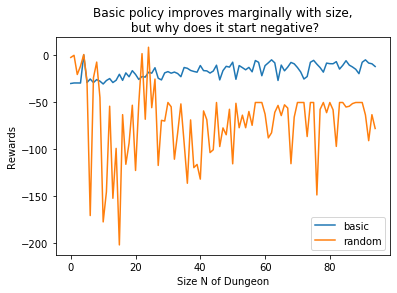

In [278]:
plt.plot(basic_av_rewards, label = 'basic')
plt.plot(av_rewards, label='random')
plt.legend()
plt.title('Basic policy improves marginally with size,\n but why does it start negative?')
plt.xlabel('Size N of Dungeon')
plt.ylabel('Rewards')

In [ ]:
#DO NOT ATTEMPT TO RUN - INFINTE LOOP

# def intelligent_policy():
#     intel_av_rewards = []
#     for N in range(5,100):
#         trial_dungeon = Dungeon(N)
#         trial_dungeon.reset()
#         target_i, target_j = trial_dungeon.target
#         for trial in range(100):
#             total_reward=0
#             while trial_dungeon.done==False:
#                 lst=[target_i, target_j]
#                 coin_toss = random.choice(lst)
#                 if coin_toss==target_i:
#                     if coin_toss>0:
#                         if trial_dungeon.proximity[0,1]==0:
#                             trial_dungeon.step('up')
#                         else:
#                             coin_toss==target_j
#                     else:
#                         if trial_dungeon.proximity[2,1]==0:
#                             trial_dungeon.step('down')
#                         else:
#                             coin_toss==target_j
#                 else:
#                     if coin_toss>0:
#                         if trial_dungeon.proximity[1,2]==0:
#                             trial_dungeon.step('right')
# #                         else:
# #                             coin_toss==target_i
#                     else:
#                         if trial_dungeon.proximity[1,0]==0:
#                             trial_dungeon.step('left')
# #                         else:
# #                             coin_toss==target_i
#                 total_reward+=(trial_dungeon.reward)
#                 av_reward=total_reward/100
#         intel_av_rewards.append(av_reward)
#     return intel_av_rewards

In [ ]:
# dungeon = Dungeon(10)
# dungeon.reset()

# print(dungeon.position_agent)
# dungeon.display()
# obs, reward, done = dungeon.step( ... )

# print(dungeon.position_agent)

# Part 2 - Defining a policy

A policy tells the agent how to act depending on its current observation and internal beliefs.

As a first simple case, we will define policy as a function that maps observations to actions.

As your agent is stupid and doesn't have any way of learning what to do, in this first lab we will write by hand the policy.
Try to come up with a strategy to terminate the game with the maximum reward.

We advise you to start with a very simple policy, then maybe try a random policy, and finally an 'intelligent' policy.


In [ ]:
def basic_policy(observation):
    
    ...
    
    return action

def random_policy(observation):
    ...
    
def intelligent_policy(observation):
    ...
    

# Part 3 - Evaluating your policy

Now that you have the environment and policies, you can simulate runs of your games under different policies and evaluate the reward that particular policies will get upon termination of the environment. 

To that effect, we will create a function run_single_experiment, which will have as input:
- an instance of an environment
- a policy

And it will return the reward obtained once the environment terminates.


In [ ]:
def run_single_exp(envir, policy):
    
    obs = envir.reset()
    done = False
    
    while not done:
        
        action = ...
        obs, reward, done = ...
        
    
    return total_reward

# Part 3 - Evaluating your policy

Now that you can evaluate how a policy performs on a particular environment, consider the following.
Because of stochasticity of initial agent position and exit position, different runs will lead to different total rewards.

To properly evaluate our policies, we must calculate the statistics over multiple runs.

To that effect, we will create a function run_experiments, which will have as input:
- an instance of an environment
- a policy
- a number of times that the experiment will be run

It will return the maximum reward obtained over all the runs, the average and variance over the rewards.


In [ ]:
def run_experiments(envir, policy, number_exp):
    
    all_rewards = []
    
    for n in range(number_exp):
        
        final_reward = run_single_exp(envir, policy)
        all_rewards.append(final_reward)
    
    max_reward = 
    mean_reward = 
    var_reward = 
    
    return max_reward, mean_reward, var_reward
    

# Part 4

Draw some plots to compare how your different policies perform depending on the environment size.

As the environment generation is also stochastic (random obstacles and lava), you might need to compute additional statistics.
